In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

 # Case Study - Three-point attempts among NBA teams
 * ## Amelia
 * ## Damien
 * ## David
 * ## Tovio

## What we planned to accomplish


* ### Is there a correlation between 3-point attempts and 2-point attempts among NBA teams?
* ### Is there a trend of 3-point attempt rates among NBA teams each year?
* ### Does the 3-point attempt rate per NBA team follow a normal distribution?

## How we organized our team

* ### We divided our tasks and formed two pair-programming teams

## What we accomplished

### Found a weak positive correlation between 3-point shot attempts rate and 2-point shots attempts
 * ### Correlation coeficcient *r* = 0.26


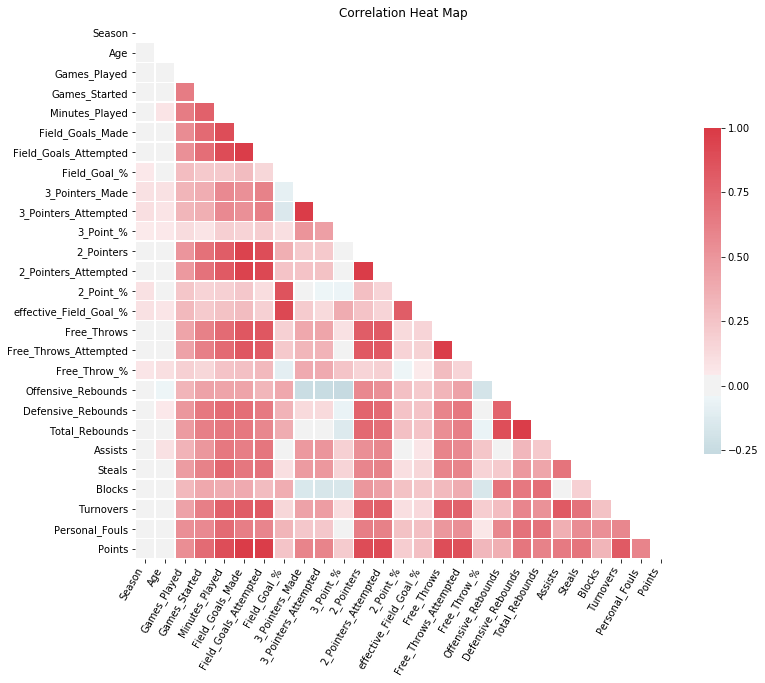

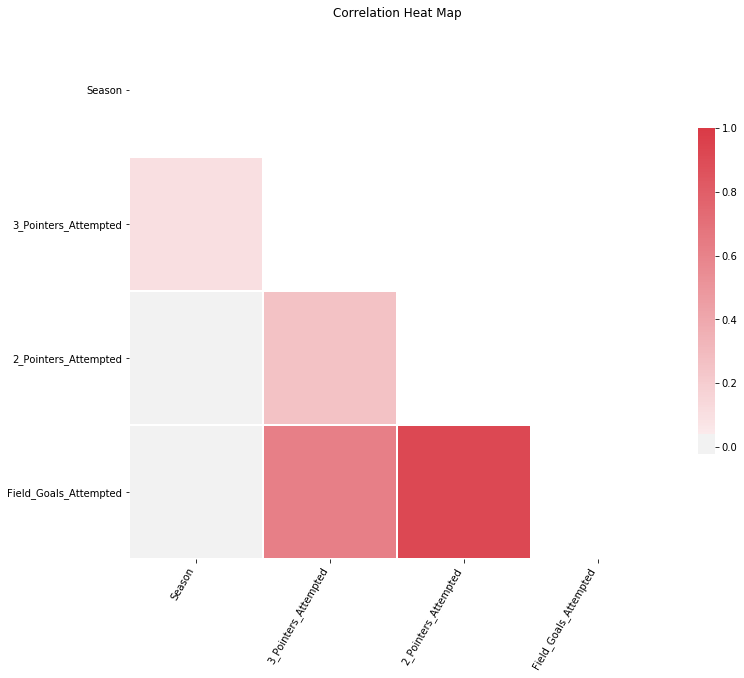

Total Correlation between 2 pointers attempted and 3 pointers attempted: 0.2623221403742481


In [3]:
def corr_heat(df):
    '''
        INPUT: a panda dataframe
        Return: none
        
        prints a heat map of the correlation between the features in the provided dataframe
    '''
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(12, 12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},xticklabels=corr.index, yticklabels=corr.columns)
    plt.xticks(rotation=60, ha="right")
    plt.yticks(rotation=0)
    ax.set_title("Correlation Heat Map")
    plt.show()
    
def covariance(x,y):
    '''
        INPUT: a numpy array or pandas scalar
        Return: the covariance of the data
    '''
    cov = 0
    x_mean = x.mean()
    y_mean = y.mean()
    cov = ((x-x_mean)*(y-y_mean)).sum()
    return cov/len(x.index)


def correlation(x,y):
    '''
        INPUT: a numpy array or pandas scalar
        Return: the correlation of the data
    '''
    return covariance(x,y)/(x.std()*y.std())

#read in the csv
nba_df = pd.read_csv("data/nba_data.csv")
#print the first heat map to get a general idea of the data
corr_heat(nba_df)
#print a smaller heat map so the variables in question are easier to see
nba_df_cleaned = nba_df[['Season', 'Team', '3_Pointers_Attempted', '2_Pointers_Attempted', 'Field_Goals_Attempted']]
corr_heat(nba_df_cleaned)
print(f"Total Correlation between 2 pointers attempted and 3 pointers attempted: {correlation(nba_df_cleaned['3_Pointers_Attempted'], nba_df_cleaned['2_Pointers_Attempted'])}")


### Plotted the 3-attempt rate for each team across multiple years using bar plots.

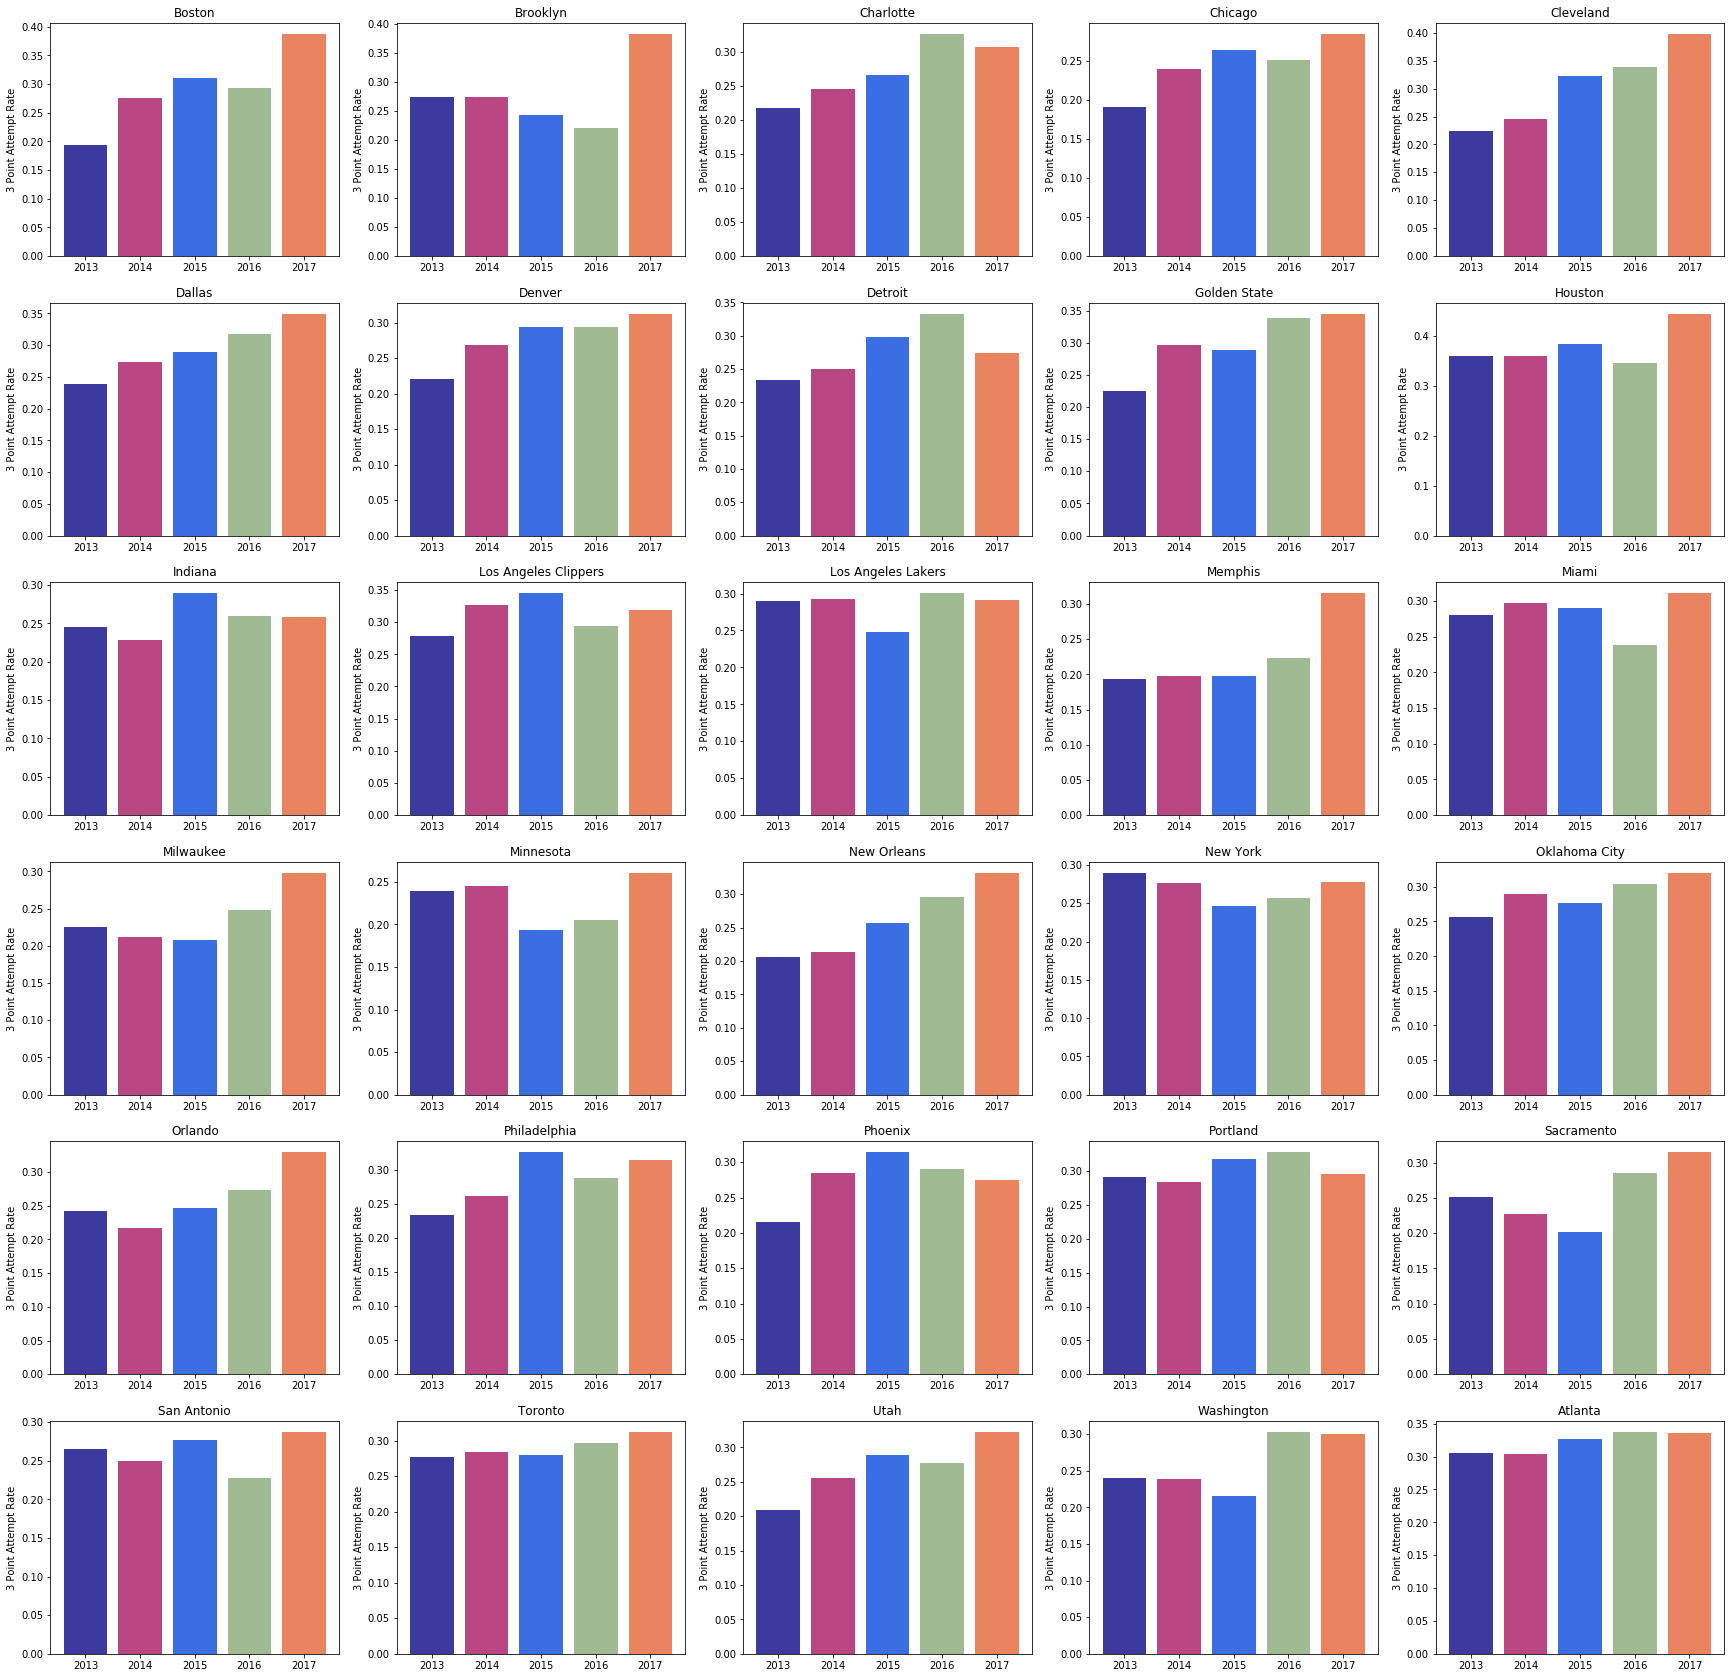

In [9]:
def add_each_graph(team_df, name, ax):
   '''
        INPUT: panda dataframe, string, graph axis
        Return: none
        
        adds a bar graph of the season to 3 pt attempt rate for the dataframe provided to the axis provided
   '''
   bargraph = ax.bar(team_df['Season'], team_df['3_pt_attempt_rate'], color=['#3c3a9c', '#b94784', '#3b6de3', '#a0ba93', '#ea835f'])
   ax.set_title(name)
   ax.set_ylabel('3 Point Attempt Rate')
    
#create copy to make changes to 
nba2 = nba_df_cleaned.copy()
#group by team and season
nba2 = pd.DataFrame(nba2.groupby(['Team', 'Season', ])['3_Pointers_Attempted', '2_Pointers_Attempted', 'Field_Goals_Attempted'].sum().reset_index()).copy()
#add 3 point attempt rate column
nba2['3_pt_attempt_rate'] = nba2['3_Pointers_Attempted']/nba2['Field_Goals_Attempted']

#create a grid of 30 axis to print on
fig, axes = plt.subplots(6,5, figsize=(30,30))
axes = axes.ravel()

#loop through each team, adding them to an axis
count = 0
teams = nba2['Team'].unique()
for team in teams:
   add_each_graph(nba2.loc[nba2['Team']== team][['3_pt_attempt_rate', 'Season']], team, axes[count-1])
   count +=1


* ### Kolmogorov-Smirnov(Ks)Test test for line of best fit:
 * ### H<sub>0</sub>: sample distribution is a normal distribution,  H<sub>A</sub>: sample distribution is not normal 
* ###  Ks test statistic = 0.53 / 0.29 with bootstrapping 95%CI 


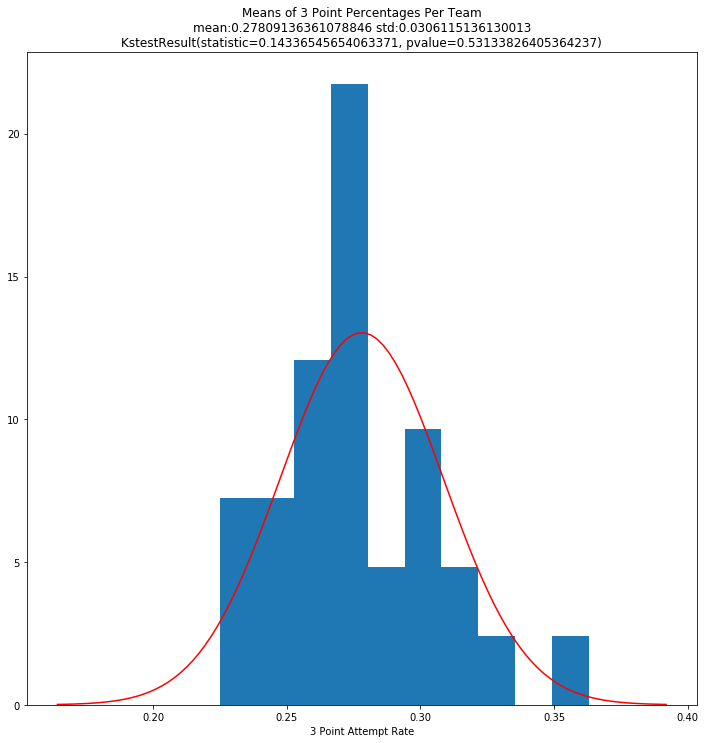

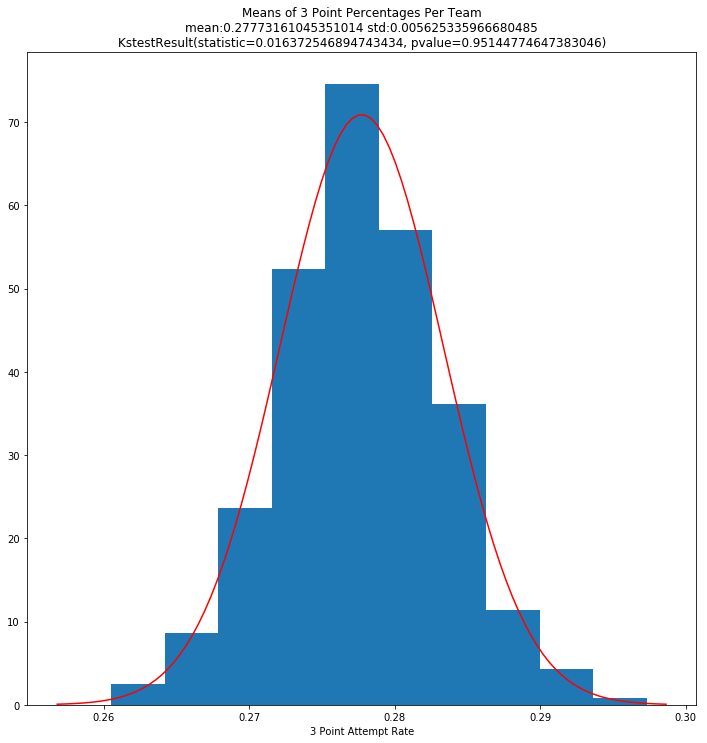

(array([ 0.26673499,  0.28948226]), 0.27773161045351014)

In [11]:
def plot_histogram_with_normal(data):
    '''simplest form of a histogram'''
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    x_range = np.linspace(stats.norm.ppf(0.0001, data.mean(), data.std()),stats.norm.ppf(0.9999, data.mean(), data.std()), 100)
    ax.hist(data, normed=True)
    normal = stats.norm.pdf(x_range, data.mean(), data.std())
    normal_line =ax.plot(x_range, normal, label='normal pmf', color='r')
    ax.set_title(f"Means of 3 Point Percentages Per Team\nmean:{data.mean()} std:{data.std()}\n{stats.kstest(data, 'norm',args=[data.mean(), data.std()])}")
    ax.set_xlabel("3 Point Attempt Rate")
    plt.show()
    
def bootstrap(sample_array, resample=10000):
    '''Implement a bootstrap function to randomly draw with replacement from a given sample. The function should take a sample as a numpy ndarray and the number of resamples as an integer (default: 10000). The function should return a list of numpy ndarray objects, each ndarray is one bootstrap sample.'''
    samples = []
    sample_array=sample_array.ravel()
    for num in range(resample):
        samples.append(np.random.choice(sample_array, len(sample_array)))
    return samples


def bootstrap_ci(sample, stat_function=np.mean, iterations=1000, ci=95):
    '''Implement a bootstrap_ci function to calculate the confidence interval of any sample statistic (in this case the mean). The function should take a sample, a function that computes the sample statistic, the number of resamples (default: 10000), and the confidence interval (default :95%). The function should return the lower and upper bounds of the confidence interval and the bootstrap distribution of the test statistic.'''
    sample_lst = bootstrap(sample, iterations)
    results = []
    for sample_set in sample_lst:
        results.append(stat_function(sample_set))
    results.sort()
    results = np.array(results)
    results_cut = results[int((len(results)*((1-(ci/100))/2))):int(len(results)-(len(results)*((1-(ci/100))/2)))]

    plot_histogram_with_normal(results)
    return (np.percentile(results, q=[(100-ci)/2,100-(100-ci)/2]), stat_function(results))

#create copy to make changes to 
nba3 = nba_df_cleaned.copy()
#add 3 point attempt rate per person
nba3['3_pt_attempt_rate'] = nba3['3_Pointers_Attempted']/nba3['Field_Goals_Attempted']
#group by team
team_averages = nba3.groupby(['Team'])['3_pt_attempt_rate'].mean()
#graph our base data set with KS test
plot_histogram_with_normal(team_averages)
#graph bootstrap data set with KS test
bootstrap_ci(team_averages)


## What we learned

### Data
* ### There is a weak positive correlation between 3-point attempt and 2-point attempt for NBA teams.
* ### There appears to be an upward trend for 3-point attempt rate of NBA teams.
* ### The sample means of the 3-point rate of the NBA teams may be normally distributed.

### Workflow
* ### Be aware of conflicting variable names among work groups.
* ### Keep an organized library of past methods for later reuse.

### Statistics
* ### Bootstrapping varies among trials.
* ### Kolmogorov-Smirnov test for goodness of fit.

### Further Exploration
* ### Perform further statistical exploration team's 3-point attempt rate yearly trend.
* ### Investigation into confounding variable for 3-point attampt rate(salaries, player heights, player).
* ### Investigation of 3-point attempt rate and offensive efficiency and win percentage.